In [1]:
import os
import cv2
import math
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import matplotlib.cm as cm
# Setting seed for reproducibiltiy
SEED = 42
tf.random.set_seed(SEED)

C:\Users\sohan\.conda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\sohan\.conda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wan

In [2]:
DATADIR = r"C:\Users\sohan\Downloads\Compressed\Training-20231217T141534Z-001\Training"
CATEGORIES = ["bcc","bkl","mel","nv"]
training_data = []
IMG_SIZE=128
def create_training_data():
    for category in CATEGORIES: 
        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
#                 pass
                print(e)
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 1260/1260 [00:09<00:00, 139.15it/s]

5040


In [3]:
random.shuffle(training_data)

In [4]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

[[[[117 125 154]
   [129 133 161]
   [124 131 159]
   ...
   [168 163 178]
   [164 160 175]
   [166 162 174]]

  [[124 129 159]
   [126 131 161]
   [127 134 160]
   ...
   [170 166 179]
   [162 159 177]
   [167 163 175]]

  [[129 133 161]
   [122 130 159]
   [133 137 161]
   ...
   [174 170 181]
   [173 169 181]
   [173 169 180]]

  ...

  [[169 167 187]
   [169 165 183]
   [172 167 188]
   ...
   [ 97 106 146]
   [ 99 107 145]
   [ 96 105 143]]

  [[172 165 183]
   [162 158 181]
   [164 160 182]
   ...
   [105 113 147]
   [ 91 101 142]
   [ 97 103 142]]

  [[168 163 179]
   [166 162 181]
   [162 160 184]
   ...
   [107 112 146]
   [ 98 108 145]
   [100 109 146]]]]


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
y_train=np.array(y_train)
y_test=np.array(y_test)
# print(x_train.shape)
# print(y_train.shape)
# type(X_test)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4032, 128, 128, 3) - y_train shape: (4032,)
x_test shape: (1008, 128, 128, 3) - y_test shape: (1008,)


In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation
from keras.initializers import glorot_uniform

In [7]:
model1 = VGG16(include_top=False,input_shape=(128, 128, 3), weights='imagenet')

In [8]:
layers_vgg = [l for l in model1.layers]

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(128, 128),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

inputs = layers_vgg[0].output

augmented = data_augmentation(inputs)


x = augmented
for i in range(1, len(layers_vgg)):
    layers_vgg[i].trainable = True
    x = layers_vgg[i](x)
#     print(4)

# Final touch
result_model = Model(layers_vgg[0].input, x)
result_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 128, 128, 3)      7         
 al)                                                             
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                             

In [9]:
transfer_layer = result_model.get_layer('block5_pool')
conv_model = Model(inputs=result_model.input, outputs=transfer_layer.output)

In [10]:
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dropout(0.5))

new_model.add(Dense(512, activation=tf.nn.gelu))
new_model.add(Dropout(0.5))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dense(512, activation=tf.nn.gelu))
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(4, activation='softmax'))

In [11]:
optimizer = Adam(lr=1e-5)
loss = 'sparse_categorical_crossentropy'
metrics = ['sparse_categorical_accuracy']


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

C:\Users\sohan\.conda\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
from keras.callbacks import ModelCheckpoint
epochs = 50

#steps_per_epoch = generator_train.n / batch_size
#steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

# Train the model with the added callback
history = new_model.fit(x=x_train, 
                        y=y_train, 
                        batch_size=32, 
                        epochs=epochs, 
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

Epoch 1/50
126/126 [==============================] - 20s 86ms/step - loss: 3.5722 - sparse_categorical_accuracy: 0.2840 - val_loss: 1.2721 - val_sparse_categorical_accuracy: 0.4345
Epoch 2/50
126/126 [==============================] - 10s 80ms/step - loss: 1.3270 - sparse_categorical_accuracy: 0.3356 - val_loss: 1.2121 - val_sparse_categorical_accuracy: 0.4871
Epoch 3/50
126/126 [==============================] - 10s 80ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.3886 - val_loss: 1.1652 - val_sparse_categorical_accuracy: 0.5377
Epoch 4/50
126/126 [==============================] - 10s 81ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.4263 - val_loss: 1.1008 - val_sparse_categorical_accuracy: 0.5040
Epoch 5/50
126/126 [==============================] - 10s 82ms/step - loss: 1.1173 - sparse_categorical_accuracy: 0.4695 - val_loss: 1.0250 - val_sparse_categorical_accuracy: 0.6280
Epoch 6/50
126/126 [==============================] - 10s 81ms/step - loss: 1.0389 - spars

In [18]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

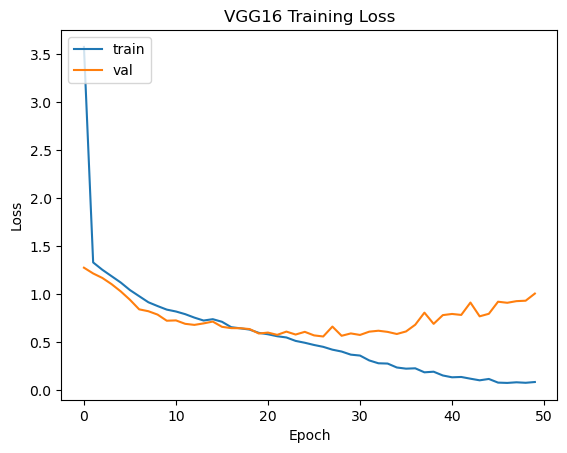

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

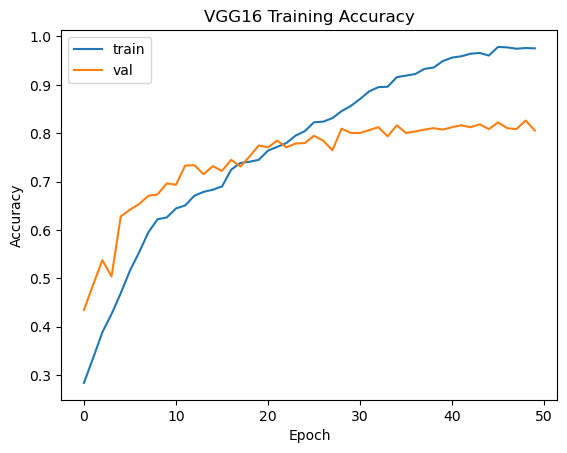

In [20]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('VGG16 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

32/32 [==============================] - 1s 30ms/step


Text(0.5, 1.0, 'Confusion Matrix From VGG16')

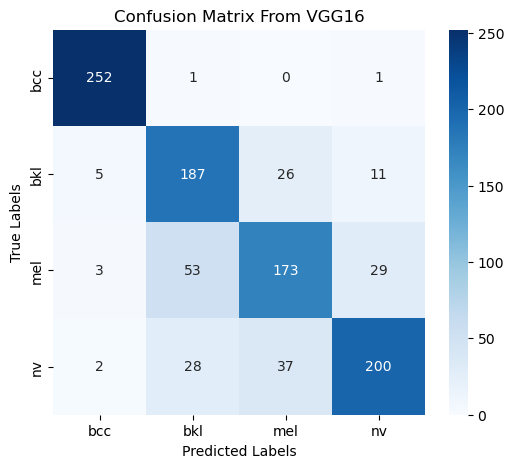

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred = new_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = ["bcc","bkl","mel","nv"],
                  columns = ["bcc","bkl","mel","nv"])
plt.figure(figsize = (6,5))
cm_plot = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
cm_plot.set_xlabel('Predicted Labels')
cm_plot.set_ylabel('True Labels')
cm_plot.set_title('Confusion Matrix From VGG16', size=12)

<AxesSubplot: >

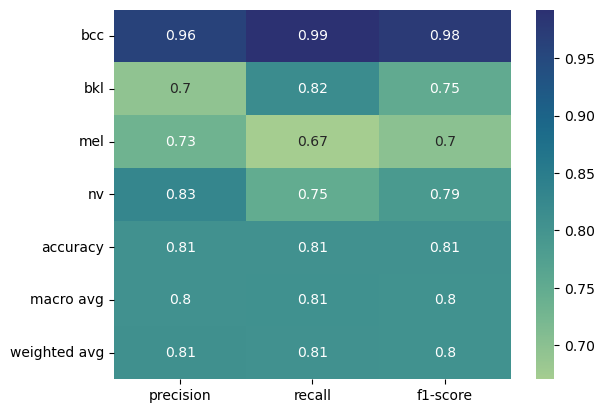

In [22]:
from sklearn.metrics import classification_report
import seaborn as sns
clf_report = classification_report(y_test, y_pred, target_names=["bcc","bkl","mel","nv"], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="crest")

1/1 [==============================] - 1s 1s/step


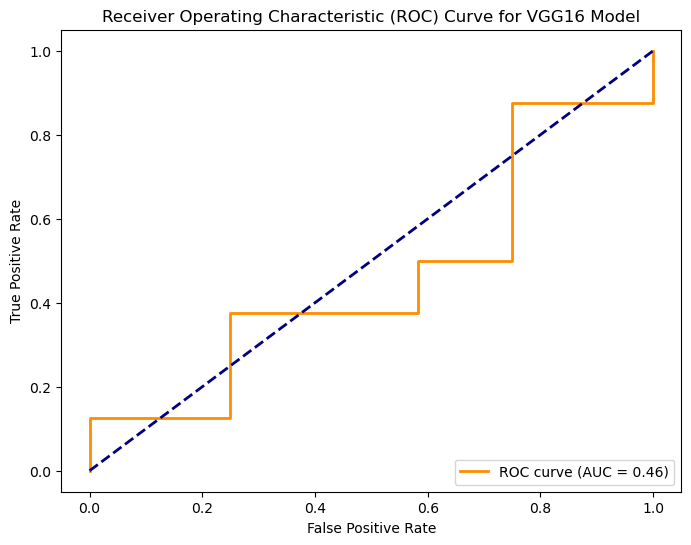

In [2]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a dataset and labels for your VGG16 model
# Replace `X` and `y` with your actual data
# For simplicity, I'm using a random example here

# Generate random dataset and labels for illustration
np.random.seed(42)
X = np.random.rand(100, 224, 224, 3)  # Random images with shape (100, 224, 224, 3)
y = np.random.randint(2, size=100)  # Binary labels (0 or 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using the pre-trained model
X_train_features = base_model.predict(preprocess_input(X_train))
X_test_features = base_model.predict(preprocess_input(X_test))

# Flatten the features
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flatten = X_test_features.reshape(X_test_features.shape[0], -1)

# Train a logistic regression model on the extracted features
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_flatten, y_train)

# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test_flatten)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for VGG16 Model')
plt.legend(loc='lower right')
plt.show()
